In [ ]:
### Imports Packages standards

import itertools
import math
import time
import numpy as np
from easydict import EasyDict as edict
import tempfile
import pandas as pd
import os
import sys

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset 
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
%cd /content/gdrive/MyDrive/Stage_M2_Jean-Eudes
!pwd

/content/gdrive/MyDrive/Stage_M2_Jean-Eudes
/content/gdrive/MyDrive/Stage_M2_Jean-Eudes


In [ ]:

dir_path  = '/content/gdrive/MyDrive/Stage_M2_Jean-Eudes'
dirs = os.listdir(dir_path)

package_path = os.path.join(dir_path,'binary-stochastic-neurons-master/')
!export PYTHON_PATH=package_path

lib_package_path= os.path.join(package_path,'distributions/')

!export PYTHONPATH=package_path:lib_package_path
!export PYTHON_PATH=package_path:lib_package_path

print (package_path)

os.chdir(package_path)

/content/gdrive/MyDrive/Stage_M2_Jean-Eudes/binary-stochastic-neurons-master/


In [ ]:
### Import packages from https://github.com/Wizaron/binary-stochastic-neurons
from activations import DeterministicBinaryActivation, StochasticBinaryActivation
from utils import Hardsigmoid

In [ ]:
use_cuda=True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
CUDA_LAUNCH_BLOCKING=1

In [ ]:
print(device)

cuda


In [ ]:
n_epochs = 10
batch_size_train = 128
batch_size_test = 256 
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [ ]:
os.chdir('/content')

In [ ]:

##load data
mnist_train = torchvision.datasets.MNIST(root='.', train=True, download=True,) #'./'
                             #transform=t)

X_mnist_train, y_mnist_train = (mnist_train.data)/255., (mnist_train.targets)
X_mnist_train = X_mnist_train.reshape((len(mnist_train),1,28,28))

mnist_test = torchvision.datasets.MNIST(root= '.',train=False, download=True,)
                             #transform=t)

X_mnist_test, y_mnist_test = (mnist_test.data)/255., (mnist_test.targets)
X_mnist_test =X_mnist_test.reshape((len(mnist_test),1,28,28))


##from Swetali codes

from numpy.fft import fftshift, ifftshift, fftn, ifftn


def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    #img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img
  
def transform_image_to_kspace(img, dim=None, k_shape=None):
  """ Computes the Fourier transform from image space to k-space space
  along a given or all dimensions
  :param img: image space data
  :param dim: vector of dimensions to transform
  :param k_shape: desired shape of output k-space data
  :returns: data in k-space (along transformed dimensions)
  """
  if not dim:
      dim = range(img.ndim)

  k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim) # fftshi()
  #k /= np.sqrt(np.prod(np.take(img.shape, dim)))
  return k


class customDataset(Dataset):
    ''' 
        Create a dataloader which takes a tuples of mnist data and "one" 
    '''    

    def __init__(self, x_mnist_data, input_1):
        self.x_mnist_data = x_mnist_data
        
        self.input_1 = input_1

        
    def __getitem__(self, index):
        sample = {'x_mnist_data': self.x_mnist_data[index], 'input_1': self.input_1[index]}
        return sample
    
    def __len__(self):
        return len(self.x_mnist_data)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
class own_minmaxscaler:

  def __init__(self, base_scaler=MinMaxScaler()):
    self.base_scaler = base_scaler


  def fit(self,train_data):
      assert train_data.ndim ==2 and  train_data.shape[1]==1 and np.iscomplexobj(train_data)==False ## we want x_train to be of shape [n,1] ==> the complexe [N,1,28,28] should be set to this shape
      self.base_scaler.fit( np.abs(train_data)  ) ## get the min and max by doing : base_scaler.data_max_ ; base_scaler.data_min_

  def transform(self,x):
    return x/self.base_scaler.data_max_

  def inverse_transform(self,x):
    return x*self.base_scaler.data_max_


def transform_data(x_train, x_test, config ,scaler = own_minmaxscaler() ):  
  config = edict(config)
  ##x_train, x_test are typically  the raw mnist data divided by 255 : X_train_mnist and X_test_mnist

  train_size = x_train.shape[0]
  test_size= x_test.shape[0]

  if config.shift_type == "tr_img_ksp":
      x_train = transform_image_to_kspace(x_train, dim=(2,3)) ## fftshift -> fftn -> ifftshift

      x_test = transform_image_to_kspace(x_test, dim=(2,3)) 

  elif config.shift_type == "none":

      x_train = np.fft.fft2(x_train, axes=(2,3)) #np.fft.fft2(x_train, axes=(2,3)) ##new_X_mnist_train is of shape 60000,28,28,1 . fft direct : il est non centré

      x_test = np.fft.fft2(x_test, axes=(2,3)) #np.fft.fft2(x_test, axes=(2,3))  

  elif config.shift_type == "simple_shift":

      x_train = np.fft.fftshift(np.fft.fft2(x_train, axes=(2,3))) #np.fft.fft2(x_train, axes=(2,3)) ##new_X_mnist_train is of shape 60000,28,28,1 . fft direct : il est non centré

      x_test = np.fft.fftshift(np.fft.fft2(x_test, axes=(2,3))) #np.fft.fft2(x_test, axes=(2,3))  


  u_train = np.vstack(( np.squeeze(x_train.real), np.squeeze(x_train.imag) ) ).flatten().reshape(-1,1)

  ##normalize kspace
  scaler.fit(u_train); x_train= scaler.transform(x_train) ; x_test= scaler.transform(x_test)

  print("max on train data",scaler.base_scaler.data_max_,"\n","min on train data", scaler.base_scaler.data_min_ )

  ##convert to torch tensor
  x_train = torch.stack((torch.from_numpy(x_train.real), torch.from_numpy(x_train.imag)),dim=-1).float().to(device) # [60000,28,28,2]
  x_test =  torch.stack((torch.from_numpy(x_test.real), torch.from_numpy(x_test.imag)),dim=-1).float().to(device)

  dataset = customDataset(x_train, torch.ones((train_size,1,1,1)).float().to(device))
  train_loader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True )

  dataset_test = customDataset(x_test , torch.ones((test_size,1,1,1)).float().to(device))
  test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False )

  return train_loader, test_loader , scaler #, x_train , x_test ##I return the scale , so that in prediction time I could rescale the predicted values

In [ ]:
config_retrieve_data = {"std_noise": 0.05,
 "dropout_proba": 0.0,
 "acc":0.25 ,
 "mask_dim": [28, 28], 
 "slope": 1,
 "slice_dim": [28, 28], 
 "main_directory": "./result", 
 "spirit_block": 5, 
 "kernel1": [5, 5], 
 "ncoils": 1, 
 "spirit_activation": "none",
 "batch_norm": False, "lr_mask": 1e-3, "lr_other": 1e-2, "auxiliary": False, "shift_type":"tr_img_ksp",
 "normalized_mse" : True,
 "n_epochs":5,
 "D2sampler": False}


_ ,_ ,_ , x_train_retrieve_data , x_test_retrieve_data = transform_data(x_train = X_mnist_train, x_test = X_mnist_test, config =config_retrieve_data ,scaler = own_minmaxscaler() )

x_train_retrieve_data = np.array(x_train_retrieve_data.cpu())
x_test_retrieve_data = np.array(x_test_retrieve_data.cpu())

max on train data [311.69804016] 
 min on train data [0.]


In [ ]:
print(x_train_retrieve_data.shape)
print(x_test_retrieve_data.shape)

(60000, 1, 28, 28, 2)
(10000, 1, 28, 28, 2)


In [ ]:
np.save("x_train_retrieve_data.npy", x_train_retrieve_data)
np.save("x_test_retrieve_data.npy", x_test_retrieve_data)

In [ ]:

u_tr = np.load("x_train_retrieve_data.npy")
u_te = np.load("x_test_retrieve_data.npy")


In [ ]:
u_tr.shape

(60000, 1, 28, 28, 2)

In [ ]:

class SparsifyBase(nn.Module):
    def __init__(self, sparse_ratio=0.5):
        super(SparsifyBase, self).__init__()
        self.sr = sparse_ratio
        self.preact = None
        self.act = None

    def get_activation(self):
        def hook(model, input, output):
            self.preact = input[0].cpu().detach().clone()
            self.act = output.cpu().detach().clone()
        return hook

    def record_activation(self):
        self.register_forward_hook(self.get_activation())      
    

class Sparsify1D_kactiveIOnline(SparsifyBase):
    def __init__(self, config):                                          
        super(Sparsify1D_kactiveIOnline, self).__init__()
        
        self.height_mask = config.mask_dim[0]
        self.width_mask = config.mask_dim[1]
        self.acc = config.acc ## acceleration en proportion
        self.slice_dim = config.slice_dim #tuple or list of the height and width of k-space
        self.D2sampler = config.D2sampler
        
        if self.D2sampler:

          self.k = int((self.slice_dim[0]*self.slice_dim[1])*self.acc)  
          self.k_per_under_mask = math.ceil((self.height_mask)*(self.width_mask) * self.k / (self.slice_dim[0]*self.slice_dim[1]))  
        
        else :        
          self.k = int((self.slice_dim[1])*self.acc)
          self.k_per_under_mask = self.k
            
    def forward(self, x):#, k=0):
        #if (k==0):
        #  k = self.k
        #else:
        #  self.k = k
        topval = x.topk(self.k_per_under_mask, dim=1)[0][:, -1]
        topval = topval.expand(x.shape[1], x.shape[0]).permute(1 ,0)
        comp = ( x>=topval).to(x)
        return comp *x

In [ ]:

class complexConv2d(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size=3, stride=1, padding = 0,dilation=1, groups=1, bias=False):
        
        super(complexConv2d, self).__init__()
        self.conv_r = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.conv_i = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)

    def forward(self,input_r, input_i):
        return self.conv_r(input_r)-self.conv_i(input_i), \
               self.conv_r(input_i)+self.conv_i(input_r)


#SPIRiT as single conv layer with kernel(centre) = 0
class Complexspirit2D(nn.Module):
    
    def __init__(self, config):
        
        super(Complexspirit2D,self).__init__()
        
        #define local variables
        self.config = config
        self.kernel_size = self.config.kernel1 
        self.ncoils = self.config.ncoils
        
        #self.nslices = config.batch_size #choosen_batch_size #self.config.nslices # REMPLACER PAR choosen_batch_size  divisible par le nombre d'exemple d'appprentissage total; le batch_size doit être = nb slice à processer
        self.conv1 = complexConv2d(in_channels= self.ncoils , out_channels=self.ncoils, kernel_size=self.kernel_size, bias=False, padding=(self.kernel_size[0]//2, self.kernel_size[1]//2))
    
    def forward(self, x):
        
        (x_real,x_img) = x[...,0],x[...,1]  
        
        with torch.no_grad():
            self.conv1.conv_r.weight[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 0
            self.conv1.conv_i.weight[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 0
        
        (x_real,x_img) = self.conv1(x_real,x_img)
        (x_real,x_img) =(torch.unsqueeze(x_real, 4), torch.unsqueeze(x_img, 4))
        
        return torch.cat((x_real,x_img),-1)

    
    
class ComplexSpiritConvBlock(nn.Module):
    """
    Model block for spirit network.
    This model applied spirit to undersampled data. A series of these blocks can be stacked to form
    the full network.
    """

    def __init__(self, model):
        """
        Args:
            model: Spirit model.
        """
        super().__init__()

        self.model = model

    def forward(self,
        current_kspace: torch.Tensor,
        ref_kspace: torch.Tensor,
        mask: torch.Tensor):
        
        x = self.model(current_kspace)
        #data consistency
        out = torch.multiply(x,1-mask) + torch.mul(ref_kspace, mask) #torch.multiply(x,~mask) + ref_kspace
        
        return out
    
    
#Stack SpiritConv N times
class ComplexstackSpirit(nn.Module):
    def __init__(self, config):
        
        super().__init__() 

        #define local variables
        self.config = config 
        
        #N times spirit is apply
        self.num_stacks = self.config.spirit_block
        
        self.body = nn.ModuleList(
            [ComplexSpiritConvBlock(Complexspirit2D(config)) for _ in range(self.num_stacks)]
        )

    def forward(self,
        masked_kspace: torch.Tensor,
        mask: torch.Tensor,):
        
        kspace_pred = masked_kspace.clone()

        for stack in self.body:
            kspace_pred = stack(kspace_pred, masked_kspace, mask)
        
        return kspace_pred


In [ ]:

class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, din):
        if self.training:
            #return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
            return din + torch.autograd.Variable(torch.randn(din.size()).to(device) * self.stddev)
        return din

In [ ]:

class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, din):
        if self.training:
            #return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
            return din + torch.autograd.Variable(torch.randn(din.size()).to(device) * self.stddev)
        return din

In [ ]:
aze = torch.ones((1,1,1,1))

bemask = nn.ConvTranspose2d(in_channels = 1, out_channels =1, kernel_size = (28, 28), groups=1, bias=False)

print(bemask.weight.shape)

torch.Size([1, 1, 28, 28])


In [ ]:
aze = torch.ones((1,1,1,1))

bemask = nn.ConvTranspose2d(in_channels = 1, out_channels =1, kernel_size = (1, 28), groups=1, bias=False)

(bemask.weight)


Parameter containing:
tensor([[[[ 0.1198, -0.1707,  0.0873, -0.0870, -0.0027, -0.0213, -0.0468,
           -0.0710,  0.1130,  0.0292,  0.0243,  0.0657, -0.1438, -0.1340,
           -0.0393,  0.0649, -0.0785,  0.1657,  0.0207, -0.0458, -0.0849,
            0.0191, -0.1330,  0.1531,  0.0002, -0.0987,  0.1676, -0.0845]]]],
       requires_grad=True)

In [ ]:
raze = bemask(aze)
raze.shape
raze

tensor([[[[ 0.1198, -0.1707,  0.0873, -0.0870, -0.0027, -0.0213, -0.0468,
           -0.0710,  0.1130,  0.0292,  0.0243,  0.0657, -0.1438, -0.1340,
           -0.0393,  0.0649, -0.0785,  0.1657,  0.0207, -0.0458, -0.0849,
            0.0191, -0.1330,  0.1531,  0.0002, -0.0987,  0.1676, -0.0845]]]],
       grad_fn=<ConvolutionBackward0>)

In [ ]:
aa = torch.tile(raze[:,:,], (28,1))
aa.shape

torch.Size([1, 1, 28, 28])

In [ ]:
aa[0,0,4,:]

tensor([ 0.1198, -0.1707,  0.0873, -0.0870, -0.0027, -0.0213, -0.0468, -0.0710,
         0.1130,  0.0292,  0.0243,  0.0657, -0.1438, -0.1340, -0.0393,  0.0649,
        -0.0785,  0.1657,  0.0207, -0.0458, -0.0849,  0.0191, -0.1330,  0.1531,
         0.0002, -0.0987,  0.1676, -0.0845], grad_fn=<SliceBackward0>)

In [ ]:


class Net(nn.Module):

    def __init__(self, bin_act_type = "determinist", k_per_under_mask = 2,config=None):
        super(Net, self).__init__()

        self.img_h = config.slice_dim[0] ##nb rows for the inmput image
        self.img_w = config.slice_dim[1] ##nb col for the inmput image
        self.height_mask = config.mask_dim[0]
        self.width_mask = config.mask_dim[1]
        self.k_per_under_mask = k_per_under_mask
        self.config = config
        self.std_noise = config.std_noise
        self.dropout_proba = config.dropout_proba                

        self.bin_act_type = bin_act_type
        
        ##only implemented for full mask
        if self.config.D2sampler == True: 
          self.conv_mask = nn.ConvTranspose2d(in_channels = 1, out_channels =1, kernel_size = (self.height_mask, self.width_mask), groups=1, bias=False)      
        else :##attention , non implementer pour les petits masques
          self.conv_mask = nn.ConvTranspose2d(in_channels = 1, out_channels =1, kernel_size = (1, self.width_mask), groups=1, bias=False) 
        
        
        self.DO1 = nn.Dropout(p = self.dropout_proba, inplace=False)
        self.noise = GaussianNoise(self.std_noise)

        self.binary_act_d = DeterministicBinaryActivation(estimator='ST')
        self.binary_act_s = StochasticBinaryActivation(estimator='ST')
        
        self.slope = config.slope #1.0
        #self.linear_sp = Sparsify1D_kactiveIOnline(self.height_mask, self.width_mask, k_per_under_mask = self.k_per_under_mask)
        self.linear_sp = Sparsify1D_kactiveIOnline(config) 
        print("Number of acquired points in the whole mask :",self.linear_sp.k ); print(f"Number of acquired points in the local mask of size {config.mask_dim} :",self.linear_sp.k_per_under_mask )
        print(f"acceleration : {self.linear_sp.acc}")
        self.spirit_nn = ComplexstackSpirit(self.config)



    def forward(self, x, my_input_1):


          sig_output = F.sigmoid((self.conv_mask(my_input_1)))       
          
          #sig_output= self.DO1(sig_output) # commente dans celui qui fonctionne

          if self.bin_act_type == "determinist": # add noise and use deterministic binary activation with

            sig_output = self.noise(sig_output) # variance plus forte ici
            x2 = sig_output.view(sig_output.size()[0],-1)        
            x2 = self.linear_sp(x2)        
            wta_output = x2.view_as(sig_output) 
                  
            #wta_output = self.linear_sp(sig_output)        
              
            binary_mask = self.binary_act_d([wta_output, self.slope]) # [batch_size,1,self.height_mask, self.width_mask]
          
          elif self.bin_act_type == "stochastic": # add noise and use deterministic binary activation with
            x2 = sig_output.view(sig_output.size()[0],-1)        
            x2 = self.linear_sp(x2)        
            wta_output = x2.view_as(sig_output)    
            binary_mask = self.binary_act_s([wta_output, self.slope]) # [batch_size,1,self.height_mask, self.width_mask], the mask is specific to each input ?


          if not self.config.D2sampler:
            binary_mask = torch.tile(binary_mask[:,:,], (self.img_h ,1)) 


          ##ajuster la taille du masque à celle de l'image                                                                      
          binary_mask_adj = torch.tile(binary_mask[:,:,], (math.ceil(self.img_h/self.height_mask),math.ceil(self.img_w/self.width_mask)))[:,:,:self.img_h,:self.img_w] # x shape :[batch_size,n_channel,h,w] ; x.shape[-2] =x.shape[-1] = 28
          ##or change the "one" input and rewrite the conv mask with convtranspose  ,with stride = dim of mask...
          
          #print("binary_mask_adj shape: ", binary_mask_adj.shape)
          #print("x avant mul shape: ", x.shape)

        
          stack_binary_mask_adj = torch.stack((binary_mask_adj, binary_mask_adj), dim=-1,)
          #print("stack_binary_mask_adj ", stack_binary_mask_adj.shape) ; print("x.shape :", x.shape)
          x  = torch.mul(stack_binary_mask_adj,x)
          reconstructed_img = self.spirit_nn(x, stack_binary_mask_adj) ##more precisely it is the reconstructed kspace
          print()
                    
          return reconstructed_img, binary_mask_adj, binary_mask  

In [ ]:

def define_opt(network, lr_mask = 1e-3, lr_other = 1e-2,algo =optim.Adam  ):


  my_list = ['conv_mask.weight']

  params = list(filter(lambda kv: kv[0] in my_list, network.named_parameters()))
  base_params = list(filter(lambda kv: kv[0] not in my_list, network.named_parameters()))
  d = dict((y, x) for x, y in base_params)
  #optimizer_mask = optim.Adam(params,lr=0.001)
  #optimizer_model = optim.Adam(base_params,lr=0.01)

  optimizer = algo([ 
                                {'params': d}, 
                                {'params': network.conv_mask.parameters(), 'lr': lr_mask} 
                                ], lr=lr_other)
  return optimizer

In [ ]:

def test_spirit_2(network,criterion,config, loader, scaler, fix_mask=False):

  network.eval()
  test_loss = 0
  output_array =[]
  input_array = []

  #print("*********** TEST *************")
  with torch.no_grad():
    for batch_idx, sample in enumerate(loader):
      input,  ones_data = sample['x_mnist_data'], sample['input_1']
    
      if fix_mask == False :
        output,  learned_mask_adj, learned_mask = network(input,ones_data) ##here the output is image
      else:
        output,  learned_mask_adj, learned_mask = network(input) ##here the output is image
      
      #print(f"test : ,{len(output)}")

      if config.normalized_mse == True:
        test_loss += criterion(output, input)/criterion(input,torch.zeros(input.shape).cpu().to(device)).item() ## I am using this formulation to be sure that I divide the sum of sq by the same denominator            

      else :
        test_loss += criterion(output, input).cpu().item()*input.size(0) #criterion_MSE(output, input).item()*input.size(0)

      output_array.append(output) 
      input_array.append(input)        

  if config.normalized_mse == True:
    test_loss /= len(loader)
  else:
    test_loss /= len(loader.dataset) ##this is the loss on the whole test set


  input_array = np.array(torch.vstack(input_array).cpu()) ;   input_array = scaler.inverse_transform(input_array)
  output_array = np.array(torch.vstack(output_array).cpu()) ; output_array = scaler.inverse_transform(output_array)


  if config.shift_type == "none":
    #print("input_array shape: ", input_array.shape)
    input_array_complex = input_array[...,0] +1j*input_array[...,1] 
    input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) #transform_kspace_to_image(input_array_complex, dim=(2,3))  #input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) 
    output_array_complex = output_array[...,0] +1j*output_array[...,1]
    output_array = np.fft.ifft2(output_array_complex,axes=(2,3))  #transform_kspace_to_image(output_array_complex, dim=(2,3))  #output_array = np.fft.ifft2(output_array_complex, axes=(2,3))


  elif config.shift_type == "simple_shift":
      input_array_complex = input_array[...,0] +1j*input_array[...,1]
      input_array = np.fft.ifft2(np.fft.ifftshift(input_array_complex),axes=(2,3)) #transform_kspace_to_image(input_array_complex, dim=(2,3))  #input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) 
      output_array_complex = output_array[...,0] +1j*output_array[...,1]
      output_array = np.fft.ifft2(np.fft.ifftshift(output_array_complex),axes=(2,3))  #transform_kspace_to_image(output_array_complex, dim=(2,3))  #output_array = np.fft.ifft2(output_array_complex, axes=(2,3))


  elif config.shift_type == "tr_img_ksp":
    input_array_complex = input_array[...,0] +1j*input_array[...,1] 
    input_array = transform_kspace_to_image(input_array_complex, dim=(2,3)) #transform_kspace_to_image(input_array_complex, dim=(2,3))  #input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) 
    output_array_complex = output_array[...,0] +1j*output_array[...,1]
    output_array = transform_kspace_to_image(output_array_complex, dim=(2,3)) #transform_kspace_to_image(output_array_complex, dim=(2,3))  #output_array = np.fft.ifft2(output_array_complex, axes=(2,3))


  
  print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
  
  #print('\nTest set: Avg. loss: {:.4f}, SSIM: {} on {} test examples\n'.format(
    #test_loss, ssim(output_array, input_array, data_range=output_array.max() - input_array.min()) , len(test_loader_spirit.dataset) ))
  
  if fix_mask == False :
    fig, ax = plt.subplots(1,3, figsize=(15,6))
    ax[0].imshow(network.conv_mask.weight.data.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    #ax[0].axis("off")
        
    #print(learned_mask.clone().cpu().shape)
    ax[1].imshow(learned_mask.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    ax[1].axis("off")
    
    ax[2].imshow(learned_mask_adj.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    ax[2].axis("off")
    plt.show()

  else :
    fig, ax = plt.subplots(1,2, figsize=(12,6))
        
    ax[0].imshow(learned_mask.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    ax[0].axis("off")
    
    ax[1].imshow(learned_mask_adj.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    ax[1].axis("off")
    plt.show()

  return np.abs(input_array), np.abs(output_array), test_loss.item(), learned_mask_adj 

In [ ]:

def get_initial_weight_mask(network, data_loader):

  network.eval()

  with torch.no_grad():
    one_batch = next(iter(data_loader))    
    input, ones_data = one_batch['x_mnist_data'], one_batch['input_1']
    init_output, init_learned_mask_adj, init_learned_mask = network(input,ones_data)
    print(input.shape)


  return network.conv_mask.weight.data.clone().cpu()[0,0,:,:], init_learned_mask_adj.clone().cpu()[0,0,:,:]

In [ ]:

def train_spirit_2(n_epochs, network, optimizer, config,loader, loader_test , scaler,saving_path = None,criterion=nn.MSELoss().to(device),fix_mask = False ):  
          
                
    train_losses = []
    test_losses = []
    learned_mask_adj_list = []
    weight_list = []
  
    if fix_mask == False :
      init_weight, init_learned_mask_adj = get_initial_weight_mask(network, loader) 
      
      weight_list.append(init_weight); learned_mask_adj_list.append(init_learned_mask_adj)

      plt.imshow(init_learned_mask_adj,cmap = "Greys_r")
      plt.axis("off")
      plt.title("initialisation mask")
      try:
        plt.savefig(os.path.join(saving_path,"initialisation_mask.png")) 
      except:
        pass    

    ##training loop
    for epoch in range(1, n_epochs + 1):
                
        running_loss = 0.0  
        network.train()
        for batch_idx, sample in enumerate(loader):                
            input, ones_data = sample['x_mnist_data'], sample['input_1']
            optimizer.zero_grad()

            if fix_mask == False :
              output,  learned_mask_adj, learned_mask = network(input,ones_data)
            else :
              #print("input",input.get_device())
              output,  learned_mask_adj, learned_mask = network(input)

            #loss = criterion(output, input)      #(sum of square)/batch_size*C*h*w

            if config.normalized_mse == True:
              loss = criterion(output, input)/criterion(input,torch.zeros(input.shape).to(device)) ## I am using this formulation to be sure that I divide the sum of sq by the same denominator            
            else :
              loss = criterion(output, input)  
            
            loss.backward()
            optimizer.step()

            if fix_mask == False :
              weight_list.append(network.conv_mask.weight.data.clone().cpu()[0,0,:,:]) ; learned_mask_adj_list.append(learned_mask_adj.clone().cpu()[0,0,:,:])

            #print("nb of pixels changed wrt previous mask : ", (torch.eq(learned_mask_adj_list[-2], learned_mask_adj_list[-1])==False).sum().item() )                        
            #print("nb of pixels changed wrt the initial mask : ", (torch.eq(learned_mask_adj_list[0], learned_mask_adj_list[-1])==False).sum().item()  )
            

            if config.normalized_mse == True:
              running_loss += loss.cpu().item()
            else:
              running_loss += loss.cpu().item() * input.size(0)  #(sum of square)/C*h*w
            
             

            if batch_idx % 200 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(input), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item())) # this is the loss for a single batch : (sum of square)/batch_size*C*h*w
                
                #inp, out, _, _ = test_spirit_2(network,criterion,config, loader = loader_test,scaler = scaler,fix_mask=fix_mask) ; plotting_reconst(inp, out,n=4)


        if config.normalized_mse == True:
          epoch_loss = running_loss/len(loader)
        else:
          epoch_loss = running_loss/len(loader.dataset) #(sum of square)/60000*C*h*w; 60000=batch_size*len(train_loader.dataset)

        train_losses.append(epoch_loss)
        print("test at the end of epoch")
        
        inp_, out_, end_test_loss, epoch_learned_mask_adj = test_spirit_2(network,criterion,config, loader = loader_test,scaler = scaler, fix_mask=fix_mask) ; test_losses.append(end_test_loss) 
        
        plt.imshow(epoch_learned_mask_adj[0,0,:,:].cpu(),cmap = "Greys_r")
        plt.axis("off")
        plt.title(f"mask_at_the_epoch_{epoch}")
        try:
          plt.savefig(os.path.join(saving_path,f"mask_at_the_epoch_{epoch}.png")) 
        except:
          pass

    if fix_mask == False :
      delta_pixels = [(torch.eq(learned_mask_adj_list[i], learned_mask_adj_list[i+1])==False).sum().item() \
                      for i in range(len(learned_mask_adj_list)-1)] #list of nb of pixels changed wrt previous mask 

      delta_weight = [((torch.linalg.vector_norm(torch.flatten(weight_list[i+1]-weight_list[i])))**2).item() \
          for i in range(len(weight_list)-1)] #list of diff in weight wrt previous weight


      delta0_pixels = [(torch.eq(learned_mask_adj_list[0],learned_mask_adj_list[i])==False).sum().item() \
                      for i in range(1,len(learned_mask_adj_list))] #nb of pixels changed wrt the initial mask

      delta0_weight = [((torch.linalg.vector_norm(torch.flatten(weight_list[i]-weight_list[0])))**2).item() \
                for i in range(1,len(weight_list))]  #list of diff in weight wrt initial weight


      fig, ax = plt.subplots(2,2, figsize=(20,10))

      ax[0,0].plot(range(1,len(delta_pixels)+1), delta_pixels)
      ax[0,0].set_title("nb of pixels changed wrt previous mask")
      ax[0,0].set_xlabel("iterations") # batch_size*nb_epochs
      ax[0,0].set_ylabel("nb of pixels")
      
      ax[0,1].plot(range(1,len(delta_weight)+1),delta_weight)
      ax[0,1].set_title("square diff in weight wrt previous weight")
      ax[0,1].set_xlabel("iterations") 
      ax[0,1].set_ylabel("weight square diff")

      ax[1,0].plot(range(1,len(delta0_pixels)+1),delta0_pixels)
      ax[1,0].set_title("nb of pixels pixels changed wrt the initial mask")
      ax[1,0].set_xlabel("iterations") 
      ax[1,0].set_ylabel("nb of pixels")

      ax[1,1].plot(range(1,len(delta0_weight)+1), delta0_weight)
      ax[1,1].set_title("diff in weight wrt initial weight")
      ax[1,1].set_xlabel("iterations") 
      ax[1,1].set_ylabel("weight square diff")

      try:
        plt.savefig(os.path.join(saving_path,"variations.png")) 
      except:
        pass
      plt.show() 

    return {"train_loss":train_losses, "test_loss":test_losses}  

In [ ]:

def plotting_reconst(groundtruth, reconstruction,mask, loader,n=3, seed= None, saving_path =None):
  ##choose n between 3 and 6
  if seed != None:
    np.random.seed(seed)     
  random_index = np.random.choice(len(loader.dataset), n)

  fig, ax = plt.subplots(2,n, figsize=(15,6))
    #plot some examples of reconstruction and their groundtruth
  for t in range(n):

        ax[0,t].imshow(groundtruth[ random_index[t],0,:,:],cmap = "Greys_r")  
        ax[0,t].set_title("groundtruth")
        ax[0,t].axis("off")    

        ax[1,t].imshow(reconstruction[ random_index[t],0,:,:],cmap = "Greys_r")
        ax[1,t].set_title("reconstruction")
        ax[1,t].axis("off")
  try:
    plt.savefig(saving_path)
  except:
    pass
  plt.show()

In [ ]:

def compute_ssim(groundtruth, reconstruction):    

    a = np.moveaxis(groundtruth, 1, -1) ## groundtruth dimension is (N,1,28,28); turn it to (N,28,28,1)
    b =  np.moveaxis(reconstruction, 1, -1)
    ssim_list = []
    psnr_list = []
    for i in range(a.shape[0]):
         ssim_i = ssim(a[i], b[i], data_range=abs(a[i].max() - b[i].min()), multichannel=True )
         psnr_i = psnr(a[i], b[i], data_range=abs(a[i].max() - b[i].min()))
    ssim_list.append(ssim_i)
    psnr_list.append(psnr_i)
    
    ##I double compute, just for comparison
    #ssim_2 = torch_ssim(torch.from_numpy(groundtruth),torch.from_numpy(reconstruction)); psnr_2 = torch_psnr(torch.from_numpy(groundtruth),torch.from_numpy(reconstruction))
    return {"test_ssim": np.mean(ssim_list), "test_psnr": np.mean(psnr_list)}#,"test_ssim2": ssim_2, "test_psnr2":psnr_2 }
    


In [ ]:

def plot_loss(dictionay,title="reconstruction loss", test=False, saving_path = None):
  print("dictionay['test_loss']", dictionay["test_loss"])
  plt.figure()
  plt.plot(np.arange(1, len(dictionay["train_loss"])+1), dictionay["train_loss"], label = "train loss") 
  if test==True:
    plt.plot(np.arange(1, len(dictionay["test_loss"])+1), dictionay["test_loss"], label = "test loss")
  plt.title(f"{title}")
  plt.ylabel("loss")
  plt.xlabel("epoch") 
  plt.legend()
  try:
    plt.savefig(saving_path) 
  except:
    pass

  plt.show()

## Learned mask

In [ ]:

def run_model(config, trainset= X_mnist_train, testset = X_mnist_test, critere = nn.MSELoss().to(device)):

    config = edict(config.copy())

    mask_dim =config.mask_dim; acc =config.acc ;bloc = config.spirit_block ; std_noise=config.std_noise; kernel=config.kernel1 ; lr_mask=config.lr_mask ; lr_other=config.lr_other 
    
    dir_name = f"mask_dim_{mask_dim[0]}_{mask_dim[1]}_acc_{acc}_spirit_bloc_{bloc}_std_noise_{std_noise}_kernel_{kernel[0]}_{kernel[1]}_lr_mask_{lr_mask}_lr_other_{lr_other}"
    
    try:
        os.mkdir(config.main_directory) ##this will be created once, the others times an error will occur due to the multiplication of config that will need to create it again
    except:
        pass
        
    try:
        save_path = os.path.join(config.main_directory, dir_name)
        os.mkdir(save_path)  
    except:
        pass

    
    train_loader, test_loader, input_scaler = transform_data(trainset, testset, config)                      

    df = pd.DataFrame(columns=['mask_dim','acc','bloc', 'kernel','std_noise','lr_mask','lr_other','test_ssim','test_psnr','test_loss',"test_loss_denorm"])
    

    print("#################################################################")

    print(f"mask_dim_{mask_dim}_acc_{acc}_spirit_bloc_{bloc}_std_noise_{std_noise}_kernel_{kernel[0]}_{kernel[1]}_lr_mask_{lr_mask}_lr_other_{lr_other}")

    reconst_network = Net(bin_act_type = "determinist", config =config).to(device)          

    optimizer_det = define_opt(reconst_network, lr_mask = config.lr_mask, lr_other = config.lr_other, algo = optim.Adam)
    
    dico_spirit_loss = train_spirit_2(config.n_epochs, reconst_network, optimizer_det, config, loader =train_loader, loader_test=test_loader,scaler = input_scaler, saving_path = save_path, criterion = critere )


    plot_loss(dico_spirit_loss,title=f"reconstruction loss for mask_dim_{mask_dim}_acc_{acc}_spirit_bloc_{bloc}_std_noise_{std_noise}_kernel_{kernel[0]}_{kernel[1]}_lr_mask_{lr_mask}_lr_other_{lr_other}", test=True, saving_path = os.path.join(save_path,"loss_curve.png"))


    test_input, test_output,test_loss, finalmask = test_spirit_2(reconst_network,criterion=critere, config =config, loader = test_loader, scaler = input_scaler)   

    ##the plotting is on denormalized input and output
    plotting_reconst(test_input , test_output,mask =finalmask,loader=test_loader, n=4, seed= 815, saving_path =os.path.join(save_path,"reconst_examples1.png"))
    plotting_reconst(test_input , test_output,mask =finalmask,loader=test_loader, n=4, seed= 23, saving_path =os.path.join(save_path,"reconst_examples2.png"))

    metrics = compute_ssim(test_input ,test_output)
    
    test_loss_denorm = critere(torch.from_numpy(test_input), torch.from_numpy(test_output)).item()

    print("average ssim and psnr on test set", metrics)
    
    line ={"mask_dim" :mask_dim, "acc":acc, "bloc" : bloc,  "std_noise" : std_noise, "kernel" :kernel,  "lr_mask" :lr_mask , "lr_other": lr_other}

    line.update(metrics); line["test_loss"] = test_loss ; line["test_loss_denorm"] = test_loss_denorm

    df = df.append(line, ignore_index=True) 

    df.to_csv(os.path.join(config.main_directory, dir_name,"result_grid_search.csv"), sep='\t',index=True)

    return reconst_network                                                 
  
    print("##########   FIN   ##########")

max on train data [311.69804016] 
 min on train data [0.]
#################################################################
mask_dim_[28, 28]_acc_0.25_spirit_bloc_5_std_noise_0.05_kernel_5_5_lr_mask_0.001_lr_other_0.01
Number of acquired points in the whole mask : 7
Number of acquired points in the local mask of size [28, 28] : 7
acceleration : 0.25

torch.Size([128, 1, 28, 28, 2])



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.9074








































































































































































































Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.4153








































































































































































































Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.3114




































































test at the end of epoch









































Test set: Avg. loss: 0.3545


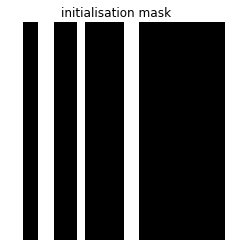

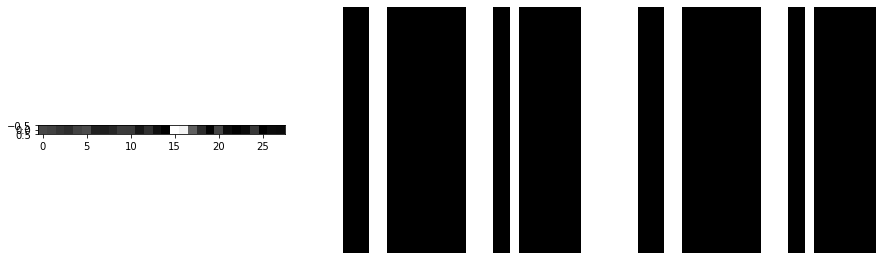


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.3180








































































































































































































Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.3260








































































































































































































Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.3040




































































test at the end of epoch









































Test set: Avg. loss: 0.2955


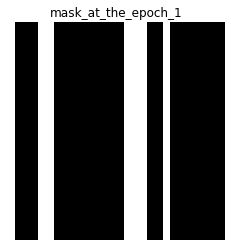

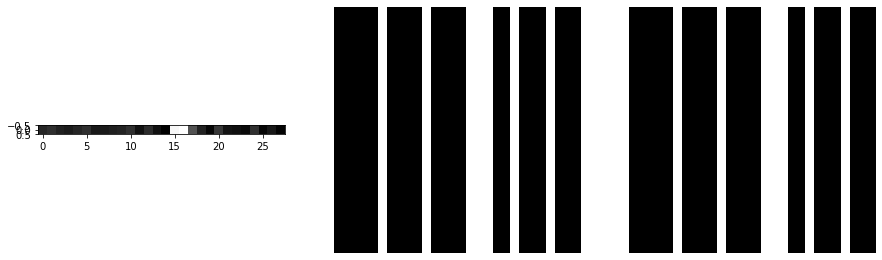


Train Epoch: 3 [0/60000 (0%)]	Loss: 0.3175








































































































































































































Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.2998








































































































































































































Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.3020




































































test at the end of epoch









































Test set: Avg. loss: 0.2950


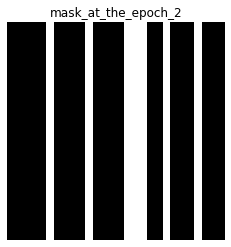

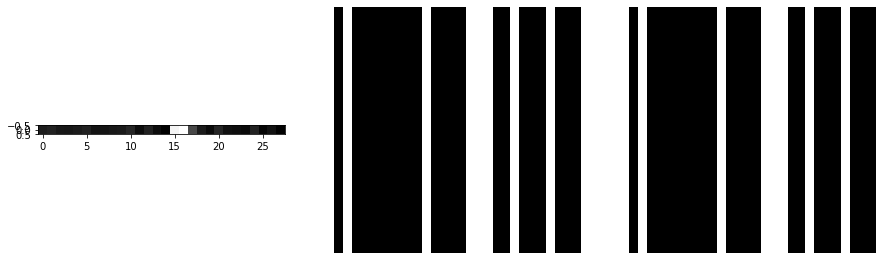


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.3159








































































































































































































Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.2871








































































































































































































Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.2873




































































test at the end of epoch









































Test set: Avg. loss: 0.2957


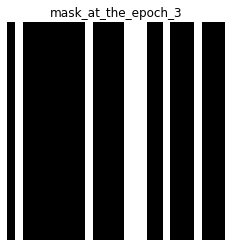

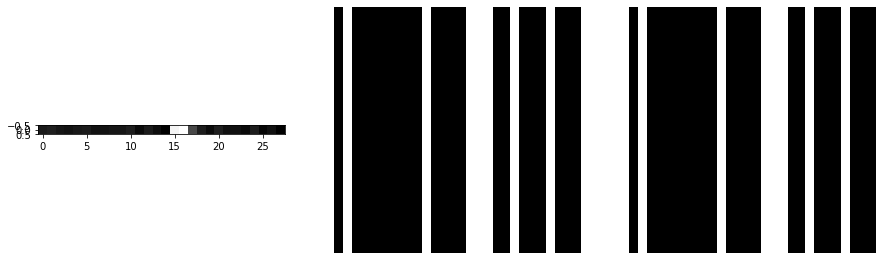


Train Epoch: 5 [0/60000 (0%)]	Loss: 0.2998








































































































































































































Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.3078








































































































































































































Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.2998




































































test at the end of epoch









































Test set: Avg. loss: 0.3325


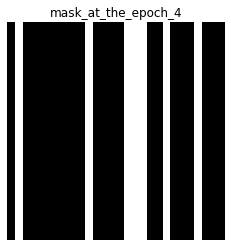

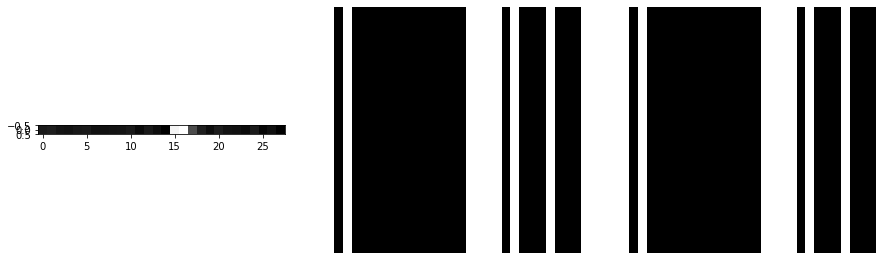

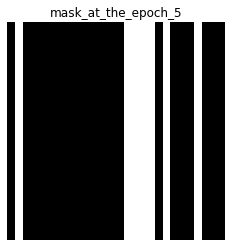

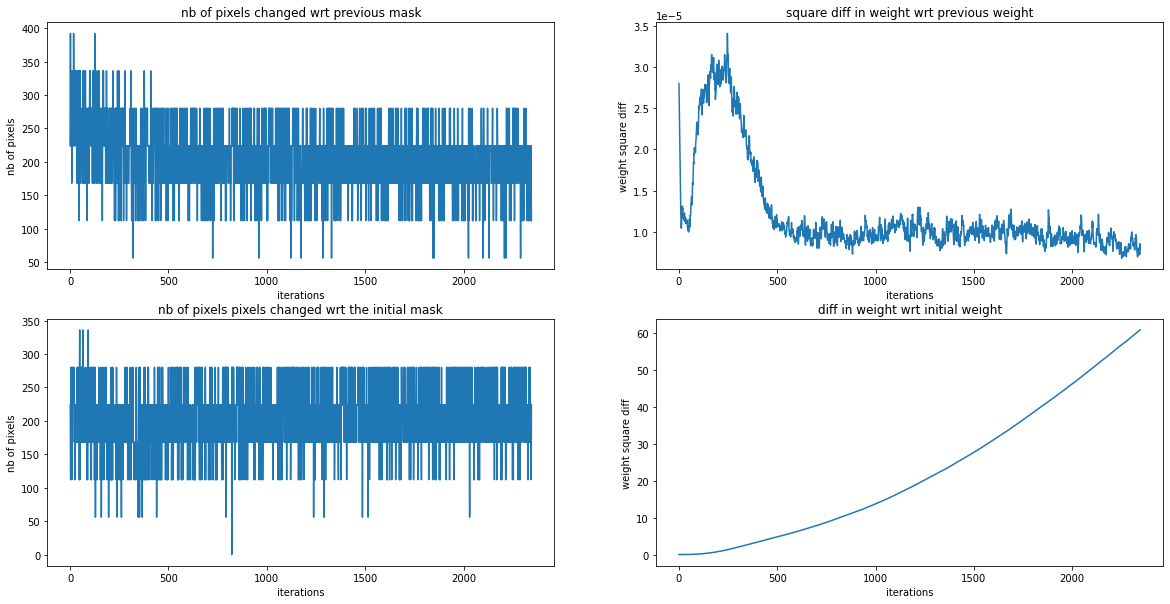

dictionay['test_loss'] [0.35451340675354004, 0.29547104239463806, 0.2949552536010742, 0.2957425117492676, 0.3324514925479889]


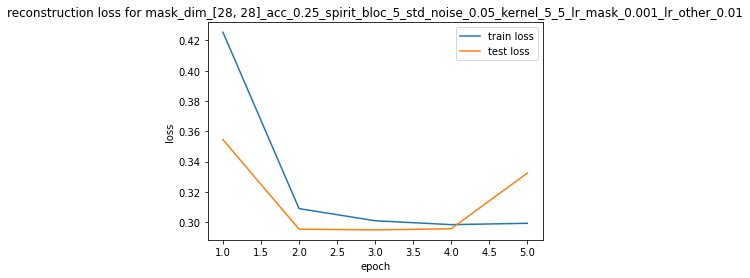

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")











































Test set: Avg. loss: 0.3325


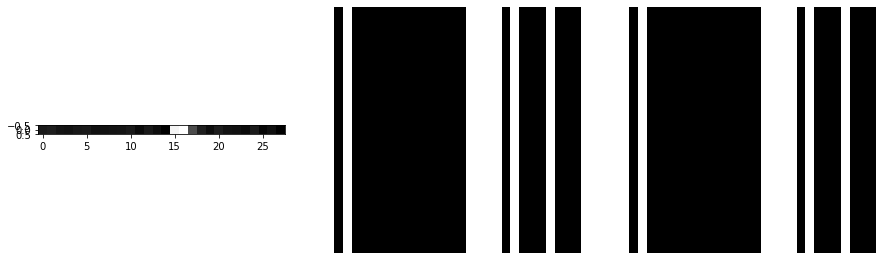

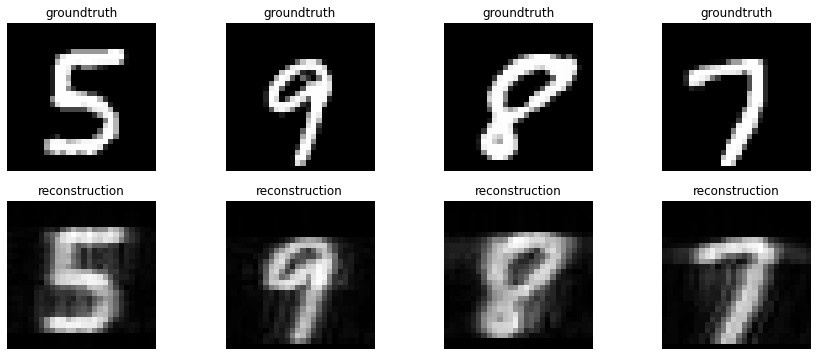

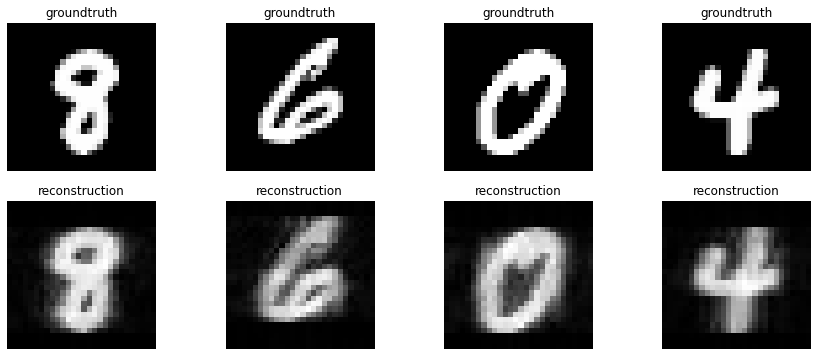

average ssim and psnr on test set {'test_ssim': 0.7158043142600721, 'test_psnr': 15.839860822646461}


In [ ]:
config = {"std_noise": 0.05,
 "dropout_proba": 0.0,
 "acc":0.25 ,
 "mask_dim": [28, 28], 
 "slope": 1,
 "slice_dim": [28, 28], 
 "main_directory": "./result", 
 "spirit_block": 5, 
 "kernel1": [5, 5], 
 "ncoils": 1, 
 "spirit_activation": "none",
 "batch_norm": False, "lr_mask": 1e-3, "lr_other": 1e-2, "auxiliary": False, "shift_type":"tr_img_ksp",
 "normalized_mse" : True,
 "n_epochs":5,
 "D2sampler": False}

myreconst_network = run_model(config)

In [ ]:
myreconst_network

## test saving model

In [ ]:
print("Model's state_dict:")
for param_tensor in myreconst_network.state_dict():
    print(param_tensor, "\t", myreconst_network.state_dict()[param_tensor].size())

Model's state_dict:
conv_mask.weight 	 torch.Size([1, 1, 1, 28])
spirit_nn.body.0.model.conv1.conv_r.weight 	 torch.Size([1, 1, 5, 5])
spirit_nn.body.0.model.conv1.conv_i.weight 	 torch.Size([1, 1, 5, 5])
spirit_nn.body.1.model.conv1.conv_r.weight 	 torch.Size([1, 1, 5, 5])
spirit_nn.body.1.model.conv1.conv_i.weight 	 torch.Size([1, 1, 5, 5])
spirit_nn.body.2.model.conv1.conv_r.weight 	 torch.Size([1, 1, 5, 5])
spirit_nn.body.2.model.conv1.conv_i.weight 	 torch.Size([1, 1, 5, 5])
spirit_nn.body.3.model.conv1.conv_r.weight 	 torch.Size([1, 1, 5, 5])
spirit_nn.body.3.model.conv1.conv_i.weight 	 torch.Size([1, 1, 5, 5])
spirit_nn.body.4.model.conv1.conv_r.weight 	 torch.Size([1, 1, 5, 5])
spirit_nn.body.4.model.conv1.conv_i.weight 	 torch.Size([1, 1, 5, 5])


In [ ]:
print("Model's state_dict:")
for param_tensor in myreconst_network.state_dict():
    print(param_tensor, "\t", myreconst_network.state_dict()[param_tensor].size())

In [ ]:
!pwd

/content


In [ ]:
torch.save(myreconst_network.state_dict(), "/content/single_line_mask_and_spirit.pt")

In [ ]:
torch.save(myreconst_network.state_dict()["conv_mask.weight"], "/content/mask.pt")

In [ ]:
config

{'D2sampler': False,
 'acc': 0.25,
 'auxiliary': False,
 'batch_norm': False,
 'dropout_proba': 0.0,
 'kernel1': [5, 5],
 'lr_mask': 0.001,
 'lr_other': 0.01,
 'main_directory': './result',
 'mask_dim': [28, 28],
 'n_epochs': 5,
 'ncoils': 1,
 'normalized_mse': True,
 'shift_type': 'tr_img_ksp',
 'slice_dim': [28, 28],
 'slope': 1,
 'spirit_activation': 'none',
 'spirit_block': 5,
 'std_noise': 0.05}

In [ ]:
eg_mask_spirit_nn = Net(bin_act_type = "determinist", config =edict(config)).to(device)   
eg_mask_spirit_nn.load_state_dict(torch.load("/content/single_line_mask_and_spirit.pt"))  
extract_spirit_nn = eg_mask_spirit_nn.spirit_nn

Number of acquired points in the whole mask : 7
Number of acquired points in the local mask of size [28, 28] : 7
acceleration : 0.25


In [ ]:
print("Model's state_dict:")
for param_tensor in extract_spirit_nn.state_dict():
    print(param_tensor, "\t", extract_spirit_nn.state_dict()[param_tensor].size())

Model's state_dict:
body.0.model.conv1.conv_r.weight 	 torch.Size([1, 1, 5, 5])
body.0.model.conv1.conv_i.weight 	 torch.Size([1, 1, 5, 5])
body.1.model.conv1.conv_r.weight 	 torch.Size([1, 1, 5, 5])
body.1.model.conv1.conv_i.weight 	 torch.Size([1, 1, 5, 5])
body.2.model.conv1.conv_r.weight 	 torch.Size([1, 1, 5, 5])
body.2.model.conv1.conv_i.weight 	 torch.Size([1, 1, 5, 5])
body.3.model.conv1.conv_r.weight 	 torch.Size([1, 1, 5, 5])
body.3.model.conv1.conv_i.weight 	 torch.Size([1, 1, 5, 5])
body.4.model.conv1.conv_r.weight 	 torch.Size([1, 1, 5, 5])
body.4.model.conv1.conv_i.weight 	 torch.Size([1, 1, 5, 5])
